### Computer Vision Project
### OpenCV and Tesseract
### Chris Lee, Serkan Comu, Jiahui Li

In [1]:
import sys, os
import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
from Levenshtein import distance
from pytesseract import Output
import imutils
import glob
import wget

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [2]:
#url = 'https://github.com/opencv/opencv_contrib/raw/master/modules/text/samples/textbox.prototxt'
#myfile = wget.download(url)
#url = 'https://www.dropbox.com/s/g8pjzv2de9gty8g/TextBoxes_icdar13.caffemodel'
#caffemodel = wget.download(url)

In [2]:
#Original Meta
meta_df = pd.read_csv("meta_data.csv")

In [3]:
#Meta Data
meta_df = pd.read_csv("meta_data_new.csv")
meta_df.head()

,XMLFile,plate_read,InstanceID,CameraID,TimeStamp,TimeStampError,LaneID,VehicleDirection,PlateNotRead,VRN,...,PlateYCoord,PlateWidth,PlateHeight,ANPRImageWidth,ANPRImageHeight,IRImage,IRImagePatch,ContextImage,ContextImagePatch,ContextVideo
0,14134_19700101194928245_BHA6172_1.xml,\n\t,14134,2,1970-01-01T15:49:28.245-0400,0,1,A,0,BHA6172,...,589,280,80,1280,1024,NaN,ir_patch/14134_19700101194928245_BHA6172_1_ir_...,context/14134_19700101194928245_BHA6172_1_cont...,NaN,NaN
1,14135_19700101195631172_BMU2999_1.xml,\n\t,14135,2,1970-01-01T15:56:31.172-0400,0,1,A,0,BMU2999,...,283,280,80,1280,1024,NaN,ir_patch/14135_19700101195631172_BMU2999_1_ir_...,context/14135_19700101195631172_BMU2999_1_cont...,NaN,NaN
2,14136_19700101195849178_PFF9889_1.xml,\n\t,14136,2,1970-01-01T15:58:49.178-0400,0,1,A,0,PFF9889,...,583,280,80,1280,1024,NaN,ir_patch/14136_19700101195849178_PFF9889_1_ir_...,context/14136_19700101195849178_PFF9889_1_cont...,NaN,NaN
3,14137_19700101200204933_PTA2105_1.xml,\n\t,14137,2,1970-01-01T16:02:04.933-0400,0,1,A,0,PTA2105,...,727,280,80,1280,1024,NaN,ir_patch/14137_19700101200204933_PTA2105_1_ir_...,context/14137_19700101200204933_PTA2105_1_cont...,NaN,NaN
4,14140_19700101200442871_CCD7351_1.xml,\n\t,14140,2,1970-01-01T16:04:42.871-0400,0,1,A,0,CCD7351,...,943,280,80,1280,1024,NaN,ir_patch/14140_19700101200442871_CCD7351_1_ir_...,context/14140_19700101200442871_CCD7351_1_cont...,NaN,NaN


In [5]:
#All
VRNs = meta_df[['VRN', 'InstanceID']]
VRNdf = pd.DataFrame(VRNs)
VRNdf.head()

,VRN,InstanceID
0,BHA6172,14134
1,BMU2999,14135
2,PFF9889,14136
3,PTA2105,14137
4,CCD7351,14140


In [6]:
#Test
VRNs = meta_df['VRN']
VRNdf = pd.DataFrame(VRNs)
VRNdf = VRNdf.head(75)
VRNdf.shape

(75, 1)

In [6]:
#images and imagepaths
images = []
imagepaths = []
for i in glob.glob("./data_redatcted/ir_patch/*.jpg"):
    img = cv2.imread(i, 0)
    imagepaths.append(i)
    images.append(img)


In [8]:
#Test
testimgs = images[0:75]

In [7]:
#image to string config
tessdata = r'C:\Program Files\Tesseract-OCR\tessdata'
whitelist = ''.join([chr(ord('A') + x) for x in range(26)]) + ''.join([str(i) for i in range(10)])
target = "--psm 7 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#psm 7: treats the image as a single text line, tessedit_char_whitelist consists of only numbes and characters

In [27]:
#Suggested Approaches
#Noise Removal(Boxing or Gaussian) #Smoothing images 
#Edges may blur a little bit in this operation 

#help(cv2.blur) 
#Blurs an image using the normalized box filter - The function smoothes am image using the kernel
#help(cv2.GaussianBlur) 
#Blurs image using the Gaussian Filter.
#help(cv2.medianBlur) 
#Takes the median value as opposed to the sum.
#help(cv2.bilateralFilter) 
#bilateralFilter can reduce unwanted noise very well while keeping edges fairly sharp. However, it is very slow compared to most filters.
def blur(image):
    return cv2.blur(image, (3,3))

def median_blue(image):
    return cv2.medianBlur(image, 5)

def gaussian_blur(image):
    return cv2.GaussianBlur(image, (5,5), 0)

#Thresholding (Adaptive Thresholding)
def global_thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)

def otsus_thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

def adaptive_thresholding_min(image):
    return cv2.adaptiveThreshold(image,  0,  cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,  5,  2)

def adaptive_thresholding_max(image):
    return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,  5,  2)

#Removing the Bounding Lines #Contours
def contouring(image):
    #testing = (~(adaptive_thresholding_max(gaussian_blur(get_grayscale(im)))))
    #plt.imshow(testing)
    contours,hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    plt.imshow(cv2.drawContours(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB), contours, -1, (255, 0, 0), 1))
    def get_contour_areas(contours):
        all_areas = []
        for cnt in contours:
            area = cv2.contourArea(cnt)
            all_areas.append(area)
        return all_areas
    get_contour_areas(contours)
    sorted_contours = sorted(contours, key = cv2.contourArea, reverse = True)
    largest = [sorted_contours[0]]
    plt.imshow(~get_rgb(cv2.drawContours(images, largest, -1, (0,255,0), 1)))

#others
#dilation
def dilate(image):
    return cv2.dilate(image, np.ones((5,5), np.uint8), iterations = 1)

#erosion
def erode(image):
    return cv2.erode(image, np.ones((5,5), np.uint8), iterations = 1)
    
#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# gray to RGB
def get_rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

In [9]:
#Prediction from original Images
initial = []
def initialp(im):
    for i in range(len(im)):
        a = pytesseract.image_to_string(im[i], config = target).replace('\n','').replace('\x0c', '').replace(' ', '')
        initial.append(a)
    VRNdf['iPrediction'] = pd.DataFrame(initial, columns = ['Initial'])
    VRNdf['iDistance'] = 0
    VRNdf['iAccuracy'] = 0
    for i in range(VRNdf.shape[0]):
        VRNdf.iloc[i,3] = distance(VRNdf.iloc[i,0], VRNdf.iloc[i,2])
        VRNdf.iloc[i,4] = str(round(((len(VRNdf.iloc[i,0]) - VRNdf.iloc[i,3]) / len(VRNdf.iloc[i,0]))*100,1)) + '%'

#Create text detector
textSpotter = cv2.text.TextDetectorCNN_create("textbox.prototxt", "TextBoxes_icdar13.caffemodel")
#Crop Images with Text Detector
croppedim = []
def cropper(im):
    for k in range(len(im)):
        ir = cv2.cvtColor(im[k], cv2.COLOR_GRAY2RGB)
        box, confidence = textSpotter.detect(ir)
        for k in range(1):
            if k >= box.shape[0]: break;
            b = box[0,:]
            newi = ir[b[1]:b[1]+b[3], b[0]:b[0]+b[2]+15]
            croppedim.append(newi)

#Predicting with Cropped Images
croppedpredict = []
def croppedp(im):
    for i in range(len(im)):
        a = pytesseract.image_to_string(im[i], config = target).replace('\n','').replace('\x0c', '').replace(' ', '')
        croppedpredict.append(a)
    VRNdf['cPrediction'] = pd.DataFrame(croppedpredict, columns = ['cPrediction'])
    VRNdf['cDistance'] = 0
    VRNdf['cAccuracy'] = 0
    for i in range(VRNdf.shape[0]):
        VRNdf.iloc[i,6] = distance(VRNdf.iloc[i,0], VRNdf.iloc[i,5])
        VRNdf.iloc[i,7] = str(round(((len(VRNdf.iloc[i,0]) - VRNdf.iloc[i,6]) / len(VRNdf.iloc[i,0]))*100,1)) + '%'

#Processing the Cropped Images
#Cropped Images already in Gray Scale
proim = []
def processed(im):
    for i in range(len(im)):
        gray = get_grayscale(im[i])
        gb = gaussian_blur(gray) #Gaussian Blur
        at = adaptive_thresholding_max(gb) #Adaptive Threshold
        #at = global_thresholding(gb) Completely removed photo
        final = get_rgb(at)
        proim.append(final)
        
#Predicting with Processed Images
processedpredict = []
def processedp(im):
    for i in range(len(im)):
        a = pytesseract.image_to_string(im[i], config = target).replace('\n','').replace('\x0c', '').replace(' ', '')
        processedpredict.append(a)
    VRNdf['pPrediction'] = pd.DataFrame(processedpredict, columns = ['pPrediction'])
    VRNdf['pDistance'] = 0
    VRNdf['pAccuracy'] = 0
    for i in range(VRNdf.shape[0]):
        VRNdf.iloc[i,9] = distance(VRNdf.iloc[i,0], VRNdf.iloc[i,8])
        VRNdf.iloc[i,10] = str(round(((len(VRNdf.iloc[i,0]) - VRNdf.iloc[i,9]) / len(VRNdf.iloc[i,0]))*100,1)) + '%'

In [11]:
#All
initialp(images)
cropper(images)
croppedp(croppedim)
processed(croppedim)
processedp(proim)

In [14]:
#Test
initialp(testimgs)
cropper(testimgs)
croppedp(croppedim)
processed(croppedim)
processedp(proim)

In [ ]:
#Part 1
initialp(images)
cropper(images)
croppedp(croppedim)

In [ ]:
#Part 2
processed(croppedim)
processedp(proim)

In [12]:
VRNdf.head()

,VRN,InstanceID,iPrediction,iDistance,iAccuracy,cPrediction,cDistance,cAccuracy,pPrediction,pDistance,pAccuracy
0,BHA6172,14134,8172,4,42.9%,,7,0.0%,,7,0.0%
1,BMU2999,14135,,7,0.0%,700,7,0.0%,7,7,0.0%
2,PFF9889,14136,PFF98892,1,85.7%,PFFOBR9,3,57.1%,PFE9R89,2,71.4%
3,PTA2105,14137,,7,0.0%,PTAZ105,1,85.7%,BTA2105,1,85.7%
4,CCD7351,14140,,7,0.0%,7351,3,57.1%,735,4,42.9%


In [17]:
#Probably Problematic Images
problems = VRNdf[(VRNdf['pDistance'] > 5) &
           (VRNdf['cDistance'] > 5) &
           (VRNdf['iDistance'] > 5)]
(list(problems['InstanceID']))

[14135,
 14159,
 14189,
 14210,
 14267,
 14272,
 14310,
 14313,
 14334,
 14339,
 14349,
 14383,
 14385,
 14397,
 14404,
 14408,
 14412,
 14459,
 14461,
 14478,
 14479,
 14484,
 14487,
 14491,
 14498,
 14555,
 14562,
 14580,
 14581,
 14583,
 14586,
 14588,
 14592,
 14628,
 14646,
 14648,
 14652,
 14656,
 14681,
 14682,
 14686,
 14687,
 14689,
 14719,
 14733,
 14737,
 14760,
 14775,
 14780,
 14788,
 14790,
 14807,
 14810,
 14815,
 14840,
 14852,
 14860,
 14862,
 14876,
 14982,
 14989,
 15014,
 15015,
 15085,
 15094,
 15105,
 15110,
 15196,
 15198,
 15202,
 15221,
 15242,
 15278,
 15283,
 15286,
 15292,
 15298,
 15318,
 15336,
 15345,
 15347,
 15379,
 15430,
 15442,
 15446,
 15458,
 15474,
 15476,
 15479,
 15501,
 15510,
 15530,
 15531,
 15570,
 15578,
 15602,
 15612,
 15617,
 15679,
 15791,
 15831,
 15835,
 15875,
 15876,
 15883,
 15927,
 15976,
 15977,
 15992,
 15996,
 15998,
 16012,
 16029,
 16033,
 16044,
 16054,
 16066,
 16075,
 16080,
 16118,
 16119,
 16126,
 16132,
 16138,
 16144,


In [21]:
problematic = list(problems['InstanceID'])
problematic
meta_df[meta_df['InstanceID'].isin(problematic)].sort_values(by = 'TimeStamp')#.to_csv('Problematic.csv')

,XMLFile,plate_read,InstanceID,CameraID,TimeStamp,TimeStampError,LaneID,VehicleDirection,PlateNotRead,VRN,...,PlateYCoord,PlateWidth,PlateHeight,ANPRImageWidth,ANPRImageHeight,IRImage,IRImagePatch,ContextImage,ContextImagePatch,ContextVideo
1155,15835_19700101055651060_PLB496_1.xml,\n\t,15835,1,1970-01-01T01:56:51.060-0400,0,1,A,0,PLB496,...,330,280,80,1280,1024,NaN,ir_patch/15835_19700101055651060_PLB496_1_ir_p...,context/15835_19700101055651060_PLB496_1_conte...,NaN,NaN
56,14210_19700101102348410_PHC8084_1.xml,\n\t,14210,2,1970-01-01T06:23:48.410-0400,0,1,A,0,PHC8084,...,813,280,80,1280,1024,NaN,ir_patch/14210_19700101102348410_PHC8084_1_ir_...,context/14210_19700101102348410_PHC8084_1_cont...,NaN,NaN
1592,16373_19700101103834670_2275AEW_1.xml,\n\t,16373,1,1970-01-01T06:38:34.670-0400,0,1,A,0,2275AEW,...,668,280,80,1280,1024,NaN,ir_patch/16373_19700101103834670_2275AEW_1_ir_...,context/16373_19700101103834670_2275AEW_1_cont...,NaN,NaN
396,14628_19700101112747998_AGY4729_1.xml,\n\t,14628,2,1970-01-01T07:27:47.998-0400,0,1,A,0,AGY4729,...,647,280,80,1280,1024,NaN,ir_patch/14628_19700101112747998_AGY4729_1_ir_...,context/14628_19700101112747998_AGY4729_1_cont...,NaN,NaN
1603,16388_19700101112918645_AYF6406_1.xml,\n\t,16388,1,1970-01-01T07:29:18.645-0400,0,1,A,0,AYF6406,...,573,280,80,1280,1024,NaN,ir_patch/16388_19700101112918645_AYF6406_1_ir_...,context/16388_19700101112918645_AYF6406_1_cont...,NaN,NaN
412,14646_19700101113950827_BUV1717_1.xml,\n\t,14646,2,1970-01-01T07:39:50.827-0400,0,1,A,0,BUV1717,...,547,280,80,1280,1024,NaN,ir_patch/14646_19700101113950827_BUV1717_1_ir_...,context/14646_19700101113950827_BUV1717_1_cont...,NaN,NaN
793,15278_19700101114327290_11184_1.xml,\n\t,15278,1,1970-01-01T07:43:27.290-0400,0,1,A,0,WL1184,...,521,280,80,1280,1024,NaN,ir_patch/15278_19700101114327290_11184_1_ir_pa...,context/15278_19700101114327290_11184_1_contex...,NaN,NaN
414,14648_19700101114420963_BQG0244_1.xml,\n\t,14648,2,1970-01-01T07:44:20.963-0400,0,1,A,0,BQG0244,...,394,280,80,1280,1024,NaN,ir_patch/14648_19700101114420963_BQG0244_1_ir_...,context/14648_19700101114420963_BQG0244_1_cont...,NaN,NaN
417,14652_19700101114716523_BWG0418_1.xml,\n\t,14652,2,1970-01-01T07:47:16.523-0400,0,1,A,0,BWG0418,...,494,280,80,1280,1024,NaN,ir_patch/14652_19700101114716523_BWG0418_1_ir_...,context/14652_19700101114716523_BWG0418_1_cont...,NaN,NaN
421,14656_19700101115106004_BSN5835_1.xml,\n\t,14656,2,1970-01-01T07:51:06.004-0400,0,1,A,0,BSN5835,...,541,280,80,1280,1024,NaN,ir_patch/14656_19700101115106004_BSN5835_1_ir_...,context/14656_19700101115106004_BSN5835_1_cont...,NaN,NaN


In [25]:
meta_df[meta_df['InstanceID'].isin(problematic)].groupby('VRN').count().sort_values(by = 'TimeStamp')

,XMLFile,plate_read,InstanceID,CameraID,TimeStamp,TimeStampError,LaneID,VehicleDirection,PlateNotRead,VRNConfidence,...,PlateYCoord,PlateWidth,PlateHeight,ANPRImageWidth,ANPRImageHeight,IRImage,IRImagePatch,ContextImage,ContextImagePatch,ContextVideo
VRN,,,,,,,,,,,,,,,,,,,,,
0XJ87M,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,0,0
DNJ916,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,0,0
DKB944,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,0,0
DJS291,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,0,0
CCJ2484,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,0,0
CBX1617,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,0,0
CBV8208,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,0,0
CBU6551,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,0,0
CBQ1847,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,0,0


In [35]:
meta_df[meta_df['VRN'] == 'ABG3352']

,XMLFile,plate_read,InstanceID,CameraID,TimeStamp,TimeStampError,LaneID,VehicleDirection,PlateNotRead,VRN,...,PlateYCoord,PlateWidth,PlateHeight,ANPRImageWidth,ANPRImageHeight,IRImage,IRImagePatch,ContextImage,ContextImagePatch,ContextVideo
595,14876_19700101175004700_ABG3352_1.xml,\n\t,14876,2,1970-01-01T13:50:04.700-0400,0,1,A,0,ABG3352,...,628,280,80,1280,1024,NaN,ir_patch/14876_19700101175004700_ABG3352_1_ir_...,context/14876_19700101175004700_ABG3352_1_cont...,NaN,NaN
626,15014_19700101194710114_ABG3352_1.xml,\n\t,15014,1,1970-01-01T15:47:10.114-0400,0,1,A,0,ABG3352,...,476,280,80,1280,1024,NaN,ir_patch/15014_19700101194710114_ABG3352_1_ir_...,context/15014_19700101194710114_ABG3352_1_cont...,NaN,NaN
961,15501_19700101164727130_ABG3352_1.xml,\n\t,15501,1,1970-01-01T12:47:27.130-0400,0,1,A,0,ABG3352,...,734,280,80,1280,1024,NaN,ir_patch/15501_19700101164727130_ABG3352_1_ir_...,context/15501_19700101164727130_ABG3352_1_cont...,NaN,NaN
994,15544_19700101181954816_ABG3352_1.xml,\n\t,15544,1,1970-01-01T14:19:54.816-0400,0,1,A,0,ABG3352,...,718,280,80,1280,1024,NaN,ir_patch/15544_19700101181954816_ABG3352_1_ir_...,context/15544_19700101181954816_ABG3352_1_cont...,NaN,NaN
1020,15573_19700101194044159_ABG3352_1.xml,\n\t,15573,1,1970-01-01T15:40:44.159-0400,0,1,A,0,ABG3352,...,718,280,80,1280,1024,NaN,ir_patch/15573_19700101194044159_ABG3352_1_ir_...,context/15573_19700101194044159_ABG3352_1_cont...,NaN,NaN
1048,15612_19700101210217189_ABG3352_1.xml,\n\t,15612,1,1970-01-01T17:02:17.189-0400,0,1,A,0,ABG3352,...,758,280,80,1280,1024,NaN,ir_patch/15612_19700101210217189_ABG3352_1_ir_...,context/15612_19700101210217189_ABG3352_1_cont...,NaN,NaN
1422,16159_19700101193916346_ABG3352_1.xml,\n\t,16159,1,1970-01-01T15:39:16.346-0400,0,1,A,0,ABG3352,...,627,280,80,1280,1024,NaN,ir_patch/16159_19700101193916346_ABG3352_1_ir_...,context/16159_19700101193916346_ABG3352_1_cont...,NaN,NaN
1474,16223_19700101205813089_ABG3352_1.xml,\n\t,16223,1,1970-01-01T16:58:13.089-0400,0,1,A,0,ABG3352,...,709,280,80,1280,1024,NaN,ir_patch/16223_19700101205813089_ABG3352_1_ir_...,context/16223_19700101205813089_ABG3352_1_cont...,NaN,NaN


PTA3790


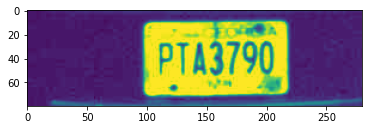

PTA3790


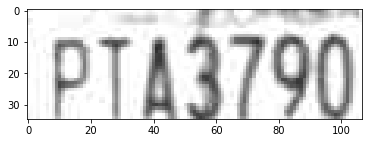

PTA3790


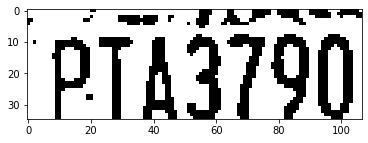

In [80]:
#imnum = 999
#imnum = 49
#imnum = 48
imnum = 13

plt.figure()

plt.imshow(images[imnum])
print(initial[imnum])
plt.show()

plt.imshow(croppedim[imnum])
print(croppedpredict[imnum])
plt.show()

plt.imshow(proim[imnum])
print(processedpredict[imnum])
plt.show()

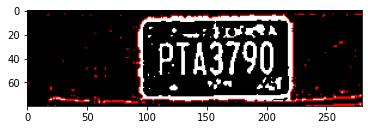

In [30]:
testing = (~(adaptive_thresholding_max(gaussian_blur(get_grayscale(get_rgb(images[13]))))))
#plt.imshow(testing)
contours,hierarchy = cv2.findContours(testing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
plt.imshow(cv2.drawContours(cv2.cvtColor(testing, cv2.COLOR_GRAY2RGB), contours, -1, (255, 0, 0), 1))

def get_contour_areas(contours):
    all_areas= []
    for cnt in contours:
        area= cv2.contourArea(cnt)
        all_areas.append(area)
    return all_areas
get_contour_areas(contours)
sorted_contours = sorted(contours, key = cv2.contourArea, reverse = True)
largest = [sorted_contours[0]]


#pytesseract.image_to_string(proim[94])

In [84]:
sorted_contours[0]
largest = [sorted_contours[0]]

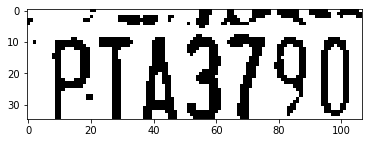

In [89]:
plt.imshow(~get_rgb(cv2.drawContours(testing, sorted_contours[0], -1, (0,255,0), 1)))

In [109]:
VRNdf.groupby('iDistance').count()

,VRN,iPrediction,iAccuracy,cPrediction,cDistance,cAccuracy,pPrediction,pDistance,pAccuracy
iDistance,,,,,,,,,
0,144,144,144,144,144,144,144,144,144
1,164,164,164,164,164,164,164,164,164
2,164,164,164,164,164,164,164,164,164
3,166,166,166,166,166,166,166,166,166
4,176,176,176,176,176,176,176,176,176
5,146,146,146,146,146,146,146,146,146
6,244,244,244,244,244,244,244,244,244
7,606,606,606,606,606,606,606,606,606
8,9,9,9,9,9,9,9,9,9


In [110]:
VRNdf.groupby('cDistance').count()

,VRN,iPrediction,iDistance,iAccuracy,cPrediction,cAccuracy,pPrediction,pDistance,pAccuracy
cDistance,,,,,,,,,
0,142,142,142,142,142,142,142,142,142
1,278,278,278,278,278,278,278,278,278
2,291,291,291,291,291,291,291,291,291
3,276,276,276,276,276,276,276,276,276
4,194,194,194,194,194,194,194,194,194
5,155,155,155,155,155,155,155,155,155
6,201,201,201,201,201,201,201,201,201
7,280,280,280,280,280,280,280,280,280
8,3,3,3,3,3,3,3,3,3


In [32]:
VRNdf.std()

InstanceID    757.372035
iDistance       2.447343
cDistance       2.269357
pDistance       2.090920
dtype: float64

In [111]:
VRNdf.groupby('pDistance').count()

,VRN,iPrediction,iDistance,iAccuracy,cPrediction,cDistance,cAccuracy,pPrediction,pAccuracy
pDistance,,,,,,,,,
0,52,52,52,52,52,52,52,52,52
1,172,172,172,172,172,172,172,172,172
2,255,255,255,255,255,255,255,255,255
3,304,304,304,304,304,304,304,304,304
4,254,254,254,254,254,254,254,254,254
5,201,201,201,201,201,201,201,201,201
6,250,250,250,250,250,250,250,250,250
7,327,327,327,327,327,327,327,327,327
8,4,4,4,4,4,4,4,4,4


In [64]:
betterthanold = pd.read_csv("BetterInitial.csv")
betterthanold.head()

,Unnamed: 0,VRN,iPrediction,iDistance,iAccuracy,cPrediction,cDistance,cAccuracy,pPrediction,pDistance,pAccuracy
0,0,BHA6172,8172,4,42.9%,NaN,7,0.0%,NaN,7,0.0%
1,1,BMU2999,NaN,7,0.0%,700,7,0.0%,7,7,0.0%
2,2,PFF9889,PFF98892,1,85.7%,PFFOBR9,3,57.1%,PFE9R89,2,71.4%
3,3,PTA2105,NaN,7,0.0%,PTAZ105,1,85.7%,BTA2105,1,85.7%
4,4,CCD7351,NaN,7,0.0%,7351,3,57.1%,735,4,42.9%


In [35]:
listed = list(VRNdf['pAccuracy'])
findacc = []
for i in listed:
    a = float(i.replace('%',''))
    findacc.append(a)
def Average(lst): 
    return sum(lst) / len(lst) 
average = Average(findacc) 
average


39.29352004393191

In [9]:
hists = pd.read_csv('Distances.csv')
ods = hists[['Distance', 'Original']]
cds = hists[['Distance', 'Cropped']]
pds = hists[['Distance', 'Processed']]

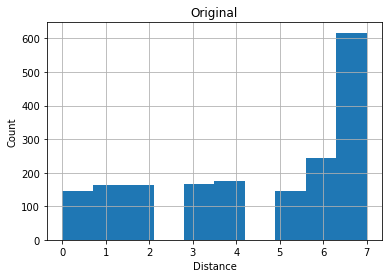

,Distance,Original
0,0,144
1,1,164
2,2,164
3,3,166
4,4,176
5,5,146
6,6,244
7,7,617


In [26]:
ods.hist('Distance', weights = ods['Original'] )
plt.ylabel('Count')
plt.xlabel('Distance')
plt.title('Original')
plt.show()
ods

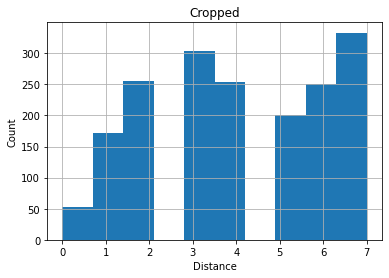

,Distance,Cropped
0,0,52
1,1,172
2,2,255
3,3,304
4,4,254
5,5,201
6,6,250
7,7,333


In [27]:
cds.hist('Distance', weights = cds['Cropped'] )
plt.ylabel('Count')
plt.xlabel('Distance')
plt.title('Cropped')
plt.show()
cds

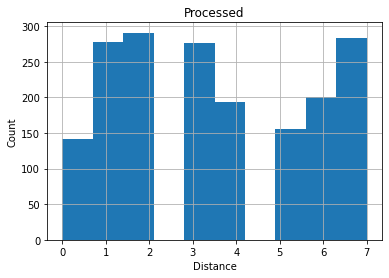

,Distance,Processed
0,0,142
1,1,278
2,2,291
3,3,276
4,4,194
5,5,155
6,6,201
7,7,284


In [28]:
pds.hist('Distance', weights = pds['Processed'] )
plt.ylabel('Count')
plt.xlabel('Distance')
plt.title('Processed')
plt.show()
pds

In [109]:
old = pd.read_csv('Initial.csv')
old.groupby('pDistance').count()

,Unnamed: 0,VRN,iPrediction,iDistance,iAccuracy,cPrediction,cDistance,cAccuracy,pPrediction,pAccuracy
pDistance,,,,,,,,,,
0,11,11,9,11,11,11,11,11,11,11
1,68,68,31,68,68,68,68,68,68,68
2,173,173,94,173,173,166,173,173,173,173
3,303,303,187,303,303,296,303,303,303,303
4,313,313,188,313,313,297,313,313,311,313
5,274,274,164,274,274,249,274,274,270,274
6,336,336,204,336,336,294,336,336,304,336
7,342,342,225,342,342,274,342,342,216,342
8,1,1,1,1,1,1,1,1,1,1


OCR: ''
[102  18  92  35]


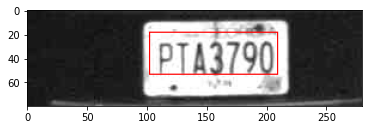

In [92]:
ocr = cv2.text_OCRTesseract.create(tessdata, 'eng', target, cv2.text.OEM_DEFAULT, cv2.text.PSM_SINGLE_LINE)

for k in range(1):
    ir = images[13]
    txt = ocr.run(ir, 10, cv2.text.OCR_LEVEL_TEXTLINE)
    print(f"OCR: '{txt}'")
    ir2 = cv2.cvtColor(ir, cv2.COLOR_GRAY2RGB)
    box, confidence = textSpotter.detect(ir2)
    print(box[0,:])

    for k in range(1):
        if k>=box.shape[0]: break;
        b = box[0,:]
        clr = [0,0,0]
        clr[k] = 255
        ir2 = cv2.rectangle(ir2, (b[0], b[1]), (b[0]+b[2]+15, b[1]+b[3]), tuple(clr), 1)
        
    plt.figure()
    plt.imshow(ir2)
    plt.show(), plt.close()
    

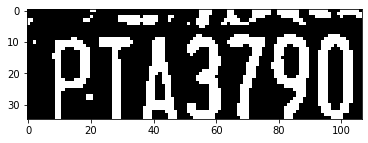

In [31]:
#Presenting Images
present = imagepaths[13]

presentim1 = cv2.imread(present)
plt.imshow(presentim1)
im = Image.fromarray(presentim1)
im.save("Image1.jpg")

presentim2 = croppedim[13]
plt.imshow(presentim2)
im = Image.fromarray(presentim2)
im.save("Image2.jpg")

plt.imshow(~get_rgb(adaptive_thresholding_max(gaussian_blur(get_grayscale(croppedim[13])))))
